## Packages

In [1]:
import os
import pathlib
import json
import math
# from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow.keras as keras

import librosa
import IPython.display as display

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import wave


2024-01-23 12:15:21.515737: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-23 12:15:21.817552: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-23 12:15:21.817741: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-23 12:15:21.857360: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-23 12:15:21.951331: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-23 12:15:21.952427: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# seed = 42
# tf.random.set_seed(seed)
# np.random.seed(seed)

## Inspect Dataset

The dataset's audio clips are stored in sixfolders corresponding to each speech command: 
- `ddyo`
- `kkono`
- `mu maaso`
- `emabega`
- `yimirira`
- `gaali`

In [3]:
DATASET_PATH = 'Dataset/'
data_dir = pathlib.Path(DATASET_PATH)

In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Commands:', commands)

Commands: ['emabega' 'ddyo' 'gaali' 'kkono' 'mu masso' 'yimirira']


### Inspect one audio file

In [5]:
audio = wave.open('Dataset/ddyo/Recording_104.wav', 'rb')

In [6]:
print('Number of channels:', audio.getnchannels())
print('Sample width      :', audio.getsampwidth())
print('frame rate        :', audio.getframerate())
print('Number of frames  :', audio.getnframes())
print('parameters        :', audio.getparams())

Number of channels: 1
Sample width      : 2
frame rate        : 16000
Number of frames  : 25600
parameters        : _wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=25600, comptype='NONE', compname='not compressed')


### Duration of a file in seconds

In [7]:
t_audio = audio.getnframes() / audio.getframerate()
print('time of audio in seconds', t_audio)

time of audio in seconds 1.6


### Visualize the audio file

In [8]:
sample_freq = audio.getframerate()
no_frames = audio.getnframes()
signal_wave = audio.readframes(-1)

In [9]:
signal_array = np.frombuffer(signal_wave, dtype='int16')
times = np.linspace(0, t_audio, no_frames)

In [10]:
times.shape

(25600,)

In [11]:
signal_array.shape

(25600,)

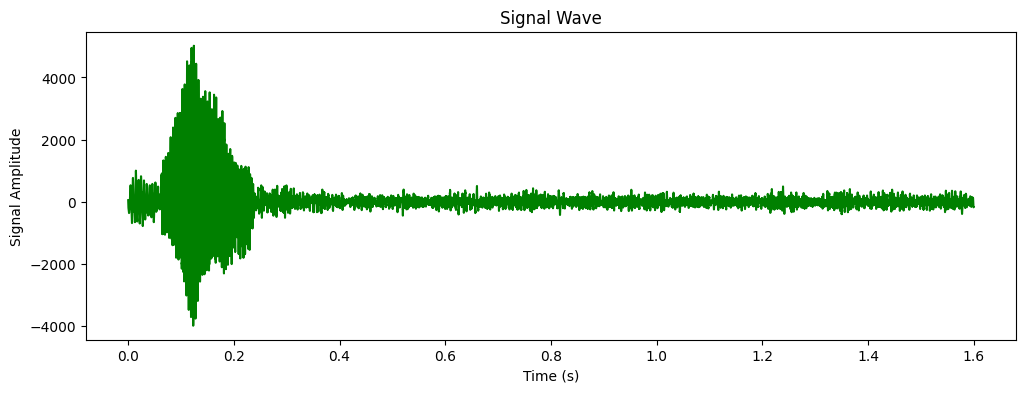

In [12]:
plt.figure(figsize=(12, 4))
plt.plot(times[:len(signal_array)], signal_array, color='green')
plt.title('Signal Wave')
plt.ylabel('Signal Amplitude')
plt.xlabel('Time (s)')
plt.show()


## Load raw data

In [13]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 126 files belonging to 6 classes.
Using 101 files for training.
Using 25 files for validation.

label names: ['ddyo' 'emabega' 'gaali' 'kkono' 'mu masso' 'yimirira']


In [14]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [15]:
# def resample_to_16_bits(audio):
#   """Resamples audio data to 16 bits.

#   Args:
#     audio: A Tensor of audio data, typically with 32-bit float dtype.

#   Returns:
#     A Tensor of audio data resampled to 16-bit integer dtype.
#   """

#   # Convert to 32-bit integers if not already
#   if audio.dtype != tf.int32:
#     audio = tf.cast(audio * 2**15, tf.int32)  # Scale to 32-bit integer range

#   # Resample to 16-bit integers
#   audio = tf.cast(audio, tf.int16)

#   return audio


In [16]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [17]:
# train_ds = train_ds.map(lambda audio, labels: (resample_to_16_bits(audio), labels),
#                          num_parallel_calls=tf.data.AUTOTUNE)
# val_ds = val_ds.map(lambda audio, labels: (resample_to_16_bits(audio), labels),
#                      num_parallel_calls=tf.data.AUTOTUNE)


In [18]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [19]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


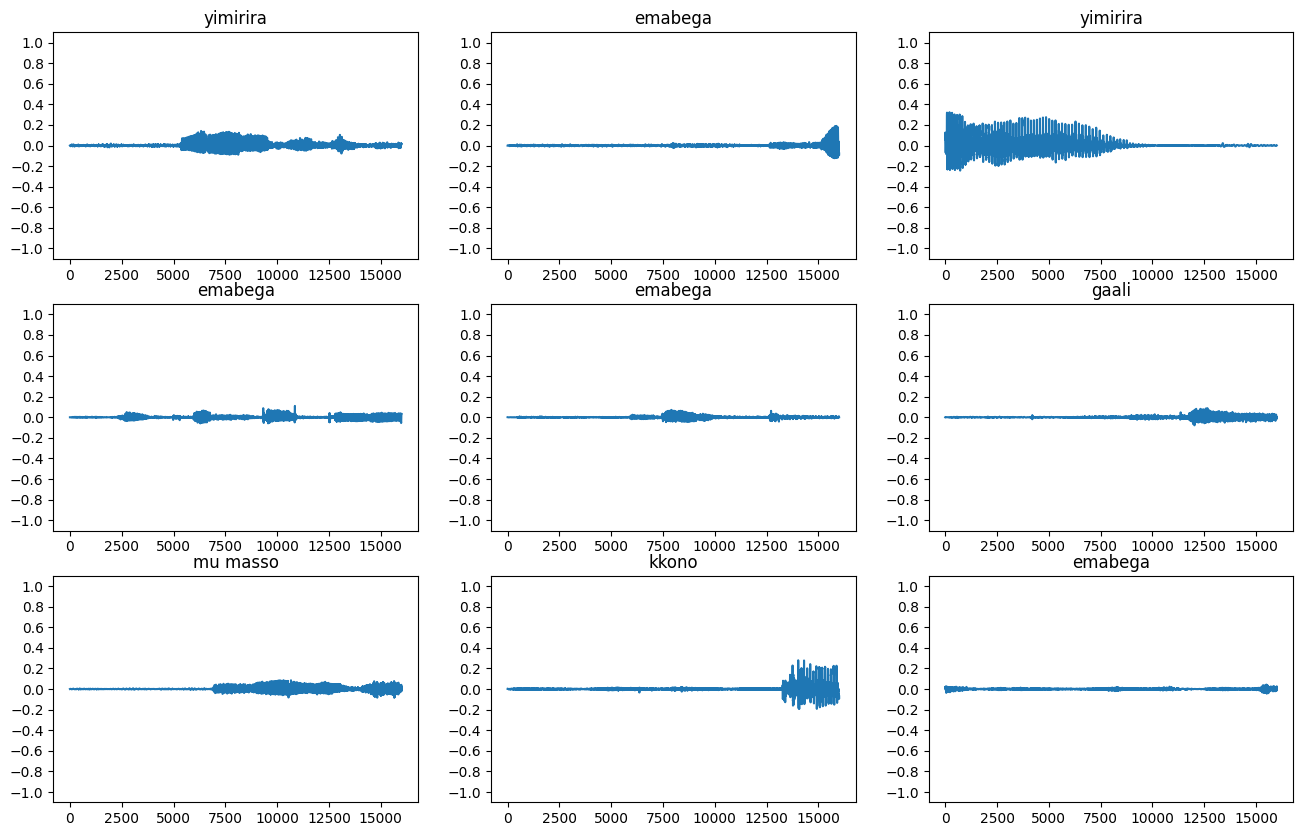

In [197]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])